<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualization-of-layer-1-conv-filters" data-toc-modified-id="Visualization-of-layer-1-conv-filters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualization of layer 1 conv filters</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Class-for-providing-images" data-toc-modified-id="Class-for-providing-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Class for providing images</a></span></li><li><span><a href="#Function-for-building-a-CNN-(using-Keras)" data-toc-modified-id="Function-for-building-a-CNN-(using-Keras)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Function for building a CNN (using Keras)</a></span></li><li><span><a href="#Function-for-training-a-CNN" data-toc-modified-id="Function-for-training-a-CNN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Function for training a CNN</a></span></li><li><span><a href="#Function-for-testing-a-CNN-model" data-toc-modified-id="Function-for-testing-a-CNN-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Function for testing a CNN model</a></span></li><li><span><a href="#Training-the-CNN" data-toc-modified-id="Training-the-CNN-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training the CNN</a></span></li></ul></div>

# Visualization of layer 1 conv filters

The goal of this notebook is to see which convolutional filters emerge in layer 1 of a CNN if train a CNN.

Since conv filters in layer 1 analyze/filter image patches, we can directly visualize the optimal input for such a filter by mapping the filter weights (that normally live in the range from -1 to +1) to an image.

Prepare a folder data with the following structure:

    data
        train
            car
            bike
        test
            car
            bike
            
and store at least some
- hundreds-1000 of images for each object category in the training subfolders
- some hundreds of images for each object category in the test subfolders


# Are all libraries that are needed available?

In [3]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib
import matplotlib.pyplot as plt

print( "Your NumPy version is:      " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is:      " + keras.__version__ )
print( "Your OpenCV version is:     " + cv2.__version__ )
print( "Your Matplotlib version is: " + matplotlib.__version__)

Using TensorFlow backend.


Your NumPy version is:      1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is:      2.2.4
Your OpenCV version is:     4.1.0
Your Matplotlib version is: 2.0.2


# Class for providing images

We define a class ``image_provider`` that will give us a convenient access to the images.

Given a root folder (e.g. "C:\\data"), it automatically determines which subfolders are there (e.g. "C:\\data\\car" and "C:\\data\\bike"). Each subfolder is assumed to be one of the categories we are interested in (e.g. "car" and "bike").

An image provide object then stores a list of all training items:
    
        [filename1, class_id, class_name, teacher_vec]
        [filename2, class_id, class_name, teacher_vec]
        ...

In [4]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (100,100)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder,
                 nr_imgs_per_class_to_use):
        
        # 1. The result of the image scan will be stored
        #    in this list
        self.all_training_items = []
       
    
        # 2. Get a list of all subfolders =
        #    a list of all image classes        
        self.class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]
        
        #print("Under folder\n\t", root_folder,
        #      "\nI found the following subfolders/classes:")
        #print(self.class_names)
    
    
        # 3. How many classes are there?
        self.nr_classes = len(self.class_names)
    
    
        # 4. For each subfolder ...
        total_nr_imgs_in_principle_available = 0
        for class_id, class_name in enumerate(self.class_names):
            
            # 4.1 Compute absolute folder name
            subfolder_name = root_folder + "/" + class_name + "/"
            
            # 4.2 Get list of image files in that class image folder
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name)
                 if isfile(join(subfolder_name, f))]
            
            #print("{} files in subfolder {}".format(len(filenames),
            #                                        subfolder_name) )
            
            # 4.3 How many images to get from that folder?
            nr_files_available = len(filenames)
            total_nr_imgs_in_principle_available += nr_files_available
            nr_files_to_store = min(nr_files_available,
                                    nr_imgs_per_class_to_use)
            
            # 4.4 For each image filename in current subfolder ...
            for file_nr in range(0,nr_files_to_store):
                
                # get next filename
                filename = filenames[file_nr]
                
                # prepare a one-hot encoded class teacher vector
                teacher_vec = np.zeros( self.nr_classes )
                teacher_vec[class_id] = 1.0
                
                # store "training item" which is mainly
                # the information of the image filename
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        
        # 5. Show how many images are in principle available
        #    and how many we "extracted" 
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available."
              .format(total_nr_imgs_in_principle_available))
        print("Since I only should extract {} images "
              "per class, I stored in total (only) {} image files."
              .format(nr_imgs_per_class_to_use, self.nr_images))        
        
        #print("Here are the first 3 entries of the training items list generated:")
        #print(self.all_training_items[:3])
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        #print("Returning random image with index", rnd_idx)
        return self.get_specific_image( rnd_idx )

Let's test the image provider class:

In [7]:
train_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train"
nr_images_to_retrieve_per_class = 100
train_img_provider = image_provider( train_folder,
                                     nr_images_to_retrieve_per_class)

There are 2000 images in total available.
Since I only should extract 100 images per class, I stored in total (only) 200 image files.


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (100, 100, 3)
teacher vec: [1. 0.]


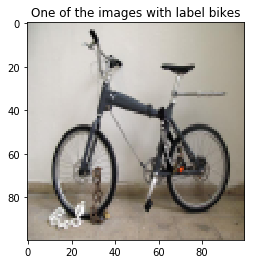

In [8]:
image, class_id, class_name, teacher_vec = \
    train_img_provider.get_random_image()
    
THE_INPUT_IMG_SHAPE = image.shape
    
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(class_name))
plt.show()

# Function for building a CNN (using Keras)

In [10]:
from keras.utils import to_categorical
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras import backend as K

def build_cnn_model(input_shape_of_single_image, nr_output_neurons):
    
    
    # clear the last Keras session
    # this will clear the underlying TensorFlow graph
    K.clear_session()

    model = Sequential()

    # 1. Define the feature hierarchy:
    
    # Layer 1
    nr_filter       = 32
    kernel_side_len = 11
    kernel_stride   = 5
    model.add(Conv2D(nr_filter,
                     kernel_size=(kernel_side_len, kernel_side_len),
                     strides=(kernel_stride, kernel_stride),
                     activation='relu',
                     input_shape=input_shape_of_single_image)
             )
    
    # Layer 2
    kernel_side_len = 2
    kernel_stride   = 2
    model.add(MaxPooling2D(pool_size=(kernel_side_len, kernel_side_len),
                           strides=(kernel_stride, kernel_stride))
             )

    # 2. Define the MLP part:
    model.add(Flatten())
    model.add(Dense(nr_output_neurons, activation='softmax'))
    
    
    # 3. Show the model
    model.summary()


    # 4. Build model and configure model for training
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model

# end build_a_cnn_model

# Function for training a CNN

In [24]:
def train_cnn_one_more_step(your_cnn, train_img_provider):
    
    height      = THE_INPUT_IMG_SHAPE[0]
    width       = THE_INPUT_IMG_SHAPE[1]
    nr_channels = THE_INPUT_IMG_SHAPE[2]

    X = np.zeros( (1,height,width,nr_channels)     )
    Y = np.zeros( (1,train_img_provider.nr_classes) )

    # 1. get the next random image from the dataset
    image, class_id, class_name, teacher_vec = \
        train_img_provider.get_random_image()

    # 2. put the image into a 4D array
    #    note: Keras expects a 4D array as input for
    #          the training function fit()
    X[0,:,:,:] = image

    
    # 3. the teacher value array expected by Keras
    #    is a 2D array
    Y[0,:] = teacher_vec

    
    # 4. train the model using this image    
    my_cnn.fit(X,Y,verbose=0)
    


# Function for testing a CNN model

In [12]:
def test_cnn(your_cnn,
             test_img_provider,
             show_example_predictions):
    
    nr_test_images = test_img_provider.nr_images
    
    correct_classified = 0
    
    print("I will test the CNN on {} test images".
          format(nr_test_images))
    
    for test_img_nr in range(0, nr_test_images):
        
        if test_img_nr % 100 == 0:
            print("Tested {} images so far".
                  format(test_img_nr))
        
        # 1. 
        # get the next test image from the
        # test image provider
        img, gt_class_nr, class_label, teacher_vec = \
            test_img_provider.get_specific_image( test_img_nr )
    
        
        # 2.
        # reshape image (3D array) to a 4D array
        # since Keras wants 4D arrays as input
        X = img.reshape((-1,
                         img.shape[0],
                         img.shape[1],
                         img.shape[2]
                        )
                       )
        
        # 3.
        # let the CNN predict the image class
        neuron_outputs = your_cnn.predict(X)
        
        # 4.
        # determine the predicted class nr
        predicted_class_nr = np.argmax(neuron_outputs.reshape(-1))
        
        # 5.
        # Did the CNN correctly predict the class?
        if predicted_class_nr == gt_class_nr:
            correct_classified +=1
        prediced_class_label = \
            test_img_provider.class_names[predicted_class_nr]
            
        # 6.
        # Show image, predicted class and gt class?
        if show_example_predictions and np.random.randint(50)==0:
                        
            plt.title("Is: {} vs. Predicted: {}\nNeuron out: {}"
                      .format(class_label,
                              prediced_class_label,
                              neuron_outputs
                             )
                     )
            plt.imshow( img )
            plt.show()
            
        
    # finally, compute the correct classification rate
    corr_classification_rate = \
        float(correct_classified) / float(nr_test_images)
        
    print("Correctly classified: {} of {} images:"
          " --> rate: {:.2f}"
          .format(correct_classified,
                  nr_test_images,
                  corr_classification_rate)
         )   
    
    # return the correct classification rate
    return corr_classification_rate
    
    

# Training the CNN

There are 2000 images in total available.
Since I only should extract 10000 images per class, I stored in total (only) 2000 image files.
There are 651 images in total available.
Since I only should extract 10000 images per class, I stored in total (only) 651 image files.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 32)        11648     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 5186      
Total params: 16,834
Trainable params: 16,834
Non-trainable params: 0
________________________________________________________________

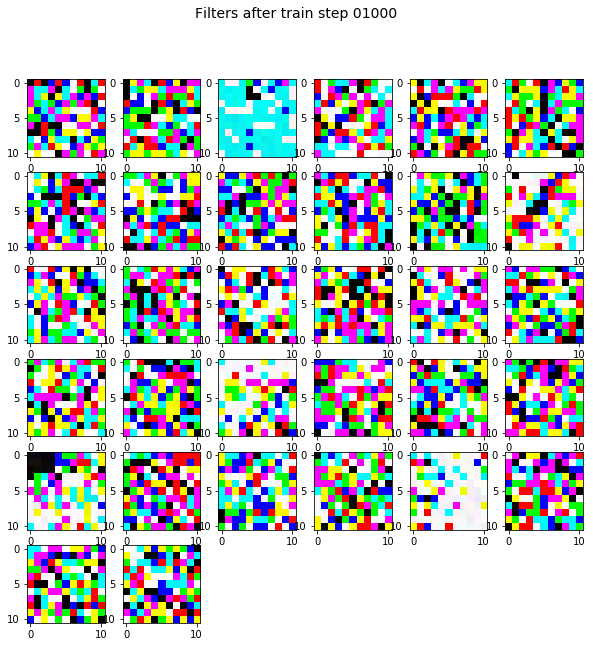

I will test the CNN on 651 test images
Tested 0 images so far
Tested 100 images so far
Tested 200 images so far
Tested 300 images so far
Tested 400 images so far
Tested 500 images so far
Tested 600 images so far
Correctly classified: 316 of 651 images: --> rate: 0.49


In [61]:
#
# Helper function that generates an image
# for each CONV layer 1 filters
# 
def visualize_filters(the_cnn, train_step):
    
    # note:
    # get_weights() returns a list with two elements:
    # list element #0: filter weights
    # list element #1: bias weights
    filter_weights_layer0 = the_cnn.layers[0].get_weights()[0]
    
    # note:
    # the weights array is a 4D Numpy array with dimension:
    #   (filter_width, filter_height, nr_channels, nr_filters)
    nr_filters = filter_weights_layer0.shape[3]
    print("There are {} filters to visualize.".format(nr_filters))
    
    # prepare a figure in which we will show
    # each filter visualization as a subplot
    size_in_inches = 10
    fig=plt.figure(figsize=(size_in_inches, size_in_inches))
    fig.suptitle("Filters after train step {:05d}"
                 .format(train_step), fontsize=14)
    columns = 6
    rows = 6
        
    for filter_nr in range(0, nr_filters):
        
        # get that filter weights 3D array
        single_filter_weights = filter_weights_layer0[:,:,:,filter_nr]
        filter_visu = single_filter_weights

        # clip weights, since weights can be negative!
        # note: unclear how to visualize negative weights
        #filter_visu = np.clip(single_filter_weights, 0.0, 1.0)
        
        # normalize weights based on maximum value
        #max_value = filter_visu.max()
        #filter_visu /= max_value
        
        # map values from [0,1] to [0,255]
        #filter_visu = np.clip(filter_visu*255.0, 0.0, 255.0)
        #filter_visu = filter_visu.astype(np.uint8)

        # show minimum, maximimum and mean of filter weights?
        if True:
            print("Min:{} Max:{} Mean:{} "
                  .format( filter_visu.min(),
                           filter_visu.max(),
                           np.mean(filter_visu) ) )  
        
        # show filter as an image
        fig.add_subplot(rows, columns, filter_nr+1)
        plt.imshow(filter_visu)
    
    # save plot as image file
    fname = "filters_{:05d}.png".format(train_step)
    plt.savefig(fname)
    
    plt.show()
    


# 1. prepare a train image provider
train_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train"
nr_images_to_retrieve_per_class = 10000
train_img_provider = image_provider( train_folder,
                                     nr_images_to_retrieve_per_class)

# 2. prepare a test image provider
test_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\test"
test_img_provider = image_provider( test_folder,
                                    nr_images_to_retrieve_per_class)


# 3. create a CNN model
    
# Always start pseudo random number generator
# with same seed in order to start CNN with
# the same weights
np.random.seed( 0 )

# Always start pseudo random number generator
# with DIFFERENT seed in order to start CNN with
# the DIFFERENT weights
#np.random.seed( model_nr )

my_cnn = build_cnn_model(THE_INPUT_IMG_SHAPE,
                         train_img_provider.nr_classes)
    


# 4. for all training steps
NR_TRAINING_STEPS = 1000
for train_step in range(0,NR_TRAINING_STEPS):
    
    # 4.1 From time to time show that we still live...
    if train_step % 500 == 0:
        print("trained {} images so far."
               .format(train_step))
    
    # 4.2 train the CNN model just _one_ more step
    train_cnn_one_more_step(my_cnn, train_img_provider)
    
    # 4.3 From time to time:
    #     Visualize conv 1 layer filters
    # visualize_filters(my_cnn, train_step)    

    
# 5. After training: visualize final filters
visualize_filters(my_cnn, NR_TRAINING_STEPS)
    
# 6. After training: test the model
show_example_predictions = False
corr_class_rate = test_cnn(my_cnn,
                           test_img_provider,
                           show_example_predictions)


In [ ]:
# Show comparison of different models as bar diagram
plt.xticks(model_ids)
plt.bar(model_ids, classification_rates)
plt.title("Comparison of classification rates")
plt.xlabel("Model nr")
plt.ylabel("Correct classifcation rate")
plt.show()

min_rate = min(classification_rates)
max_rate = max(classification_rates)

print("Minimum rate:", min_rate)
print("Maximum rate:", max_rate)
print("Range in percent:", (max_rate-min_rate)*100.0)

print("\n",classification_rates)